# Workflow for processing Lake George field data 05APR2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 11})

### Set up input and output directories etc

In [2]:
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/5_april_2018/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/LKG-05APR18/'

#
# field_data is in the format: Field Site Name, Date, Site number, Satellite Name
#
field_data = ['LKG', '05APR18', '', 'Sentinel2b']

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
bad_grounds = []
#bad_grounds = ['lkg_line300037.asd.rad']
bad_pans = []
#bad_pans = ['lkg_line500038.asd.rad', 'lkg_line500039.asd.rad', 'lkg_line300000.asd.rad', 
#            'lkg_line300001.asd.rad', 'lkg_line400000.asd.rad', 'lkg_line400001.asd.rad']

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.08296153846153846, 0.022324519230769235, 0.013778846153846155],
                          ['band2', 0.08296153846153846, 0.022324519230769235, 0.013778846153846155],
                          ['band3', 0.12335192307692308, 0.04670336538461539, 0.020809134615384618],
                          ['band4', 0.13698125, 0.05258990384615385, 0.022335096153846157],
                          ['band5', 0.13698125, 0.05258990384615385, 0.022335096153846157],
                          ['band6', 0.13698125, 0.05258990384615385, 0.022335096153846157],
                          ['band7', 0.2599456730769231, 0.15204807692307692, 0.026766346153846154],
                          ['band8', 0.2599456730769231, 0.15204807692307692, 0.026766346153846154],
                          ['band8a', 0.2599456730769231, 0.15204807692307692, 0.026766346153846154],
                          ['band11', 0.3260600961538462, 0.17622932692307694, 0.03610625],
                          ['band12', 0.24020480769230773, 0.0882, 0.037224519230769235],
                         ])

#
# Inner pixels specification
#
inpix = [2, 4, 2, 4]

### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [3]:
if field_data[3] == 'Landsat8':
    dc = datacube.Datacube()

elif field_data[3] == 'Sentinel2a' or 'Sentinel2b':
    dc = datacube.Datacube(config='/home/547/aw3463/.sent2.conf', env='sentinel2beta')

else:
    print('Satellite name should be one of Landsat8 or Sentinel2a/b. I got', field_data[3])
    
query = {
         'time': ('2018-03-28', '2018-04-06'),
         'lat': (-35.0930, -35.0920),
         'lon': (149.4613, 149.4627),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
        }

query2 = {
         'time': ('2018-03-28', '2018-04-06'),
         'lat': (-35.1030, -35.0820),
         'lon': (149.4513, 149.4727),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
        }

### LANDSAT 8 DATASET

sat_array, sat_bigarray = CreateSatArrays.create_sat_arrays(dc, query, query2, field_data)

In [4]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
suffix = 'asd.rad.txt'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'
suffix2 = 'asd.ref.sco.txt'

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/sentinel2a_all.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/sentinel2a_all.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1

### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [5]:
alldata = LoadData.load_from_dir(indir, suffix, firstGoodLine)

alldata[alldata['Wavelength']==350]

,Wavelength,radiance,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number,SWIR1_gain,SWIR1_offset,SWIR2_gain,SWIR2_offset
0,350,0.113177,lkg_5-4-18-l100000.asd.rad,2018-04-05 00:12:45,-35.092925,149.462412,1,0,18179/2,62,2062,43,2089
0,350,0.113065,lkg_5-4-18-l100001.asd.rad,2018-04-05 00:12:49,-35.092922,149.462428,1,1,18179/2,62,2062,43,2089
0,350,0.005421,lkg_5-4-18-l100002.asd.rad,2018-04-05 00:13:03,-35.092972,149.462322,1,2,18179/2,62,2062,43,2089
0,350,0.005748,lkg_5-4-18-l100003.asd.rad,2018-04-05 00:13:07,-35.092978,149.462313,1,3,18179/2,62,2062,43,2089
0,350,0.005892,lkg_5-4-18-l100004.asd.rad,2018-04-05 00:13:10,-35.092962,149.462318,1,4,18179/2,62,2062,43,2089
0,350,0.005739,lkg_5-4-18-l100005.asd.rad,2018-04-05 00:13:14,-35.092963,149.462277,1,5,18179/2,62,2062,43,2089
0,350,0.005931,lkg_5-4-18-l100006.asd.rad,2018-04-05 00:13:18,-35.092952,149.462242,1,6,18179/2,62,2062,43,2089
0,350,0.006412,lkg_5-4-18-l100007.asd.rad,2018-04-05 00:13:21,-35.092952,149.462227,1,7,18179/2,62,2062,43,2089
0,350,0.006663,lkg_5-4-18-l100008.asd.rad,2018-04-05 00:13:25,-35.092943,149.462177,1,8,18179/2,62,2062,43,2089
0,350,0.006318,lkg_5-4-18-l100009.asd.rad,2018-04-05 00:13:29,-35.092933,149.462112,1,9,18179/2,62,2062,43,2089


In [6]:
#
# Uncommenting the following line allows jupyter notebook to show more lines.
# This is needed when looking into the details of long dataframes/lists etc.
#
#pd.options.display.max_rows = 5000

### Specify which spectra are panels/ground/good/bad

 Determine panel file names by assuming that all panels have a data value of at least 0.06
 in the first wavelength (350nm). Call this dataframe 'panel_names'.

 good_panels = all panel data with bad panels removed<BR>
 bad_panels  = all bad panel data<BR>
 all_panels = both good and bad panel data<BR>
 good_grounds = good ground readings<BR>
 all_grounds = all ground data.<P>
 Any bad ground data (bad_grounds) is defined in the 2nd cell.


In [7]:
panel_names, all_panels, good_panels, bad_panels, good_grounds, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(alldata, bad_pans, bad_grounds)

### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

In [8]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
try:
    bad_panel_spec = MakeSpecDF.make_spec_df(bad_panels)
except UnboundLocalError:
    pass

# Figure 

### Plot panel radiances for all/good/bad panels

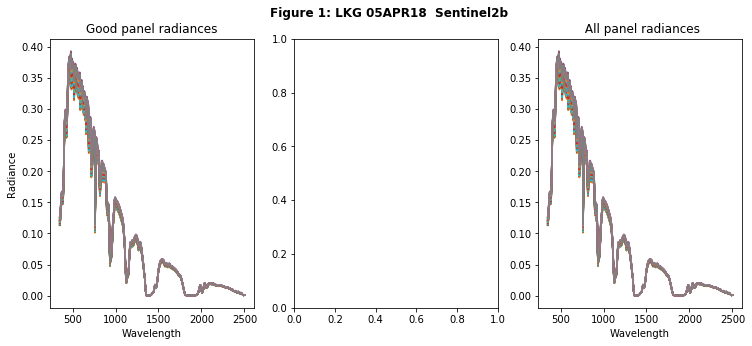

In [9]:
try:
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)
except NameError:
    bad_panel_spec = [0,0]
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)

fignum += 1

# Figure 

### Diagnosis plots of bad panel spectra

In [10]:
good_panel_mean = good_panel_spec.mean(axis=1)

try:
    FIG_BadPanelAnalysis.FIG_bad_panel_analysis(good_panel_mean, good_panel_spec, bad_panel_spec, output, field_data, fignum)
except AttributeError:
    pass
fignum +=1

### Create spectral dataframes for all ground spectra and good ground spectra

In [11]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

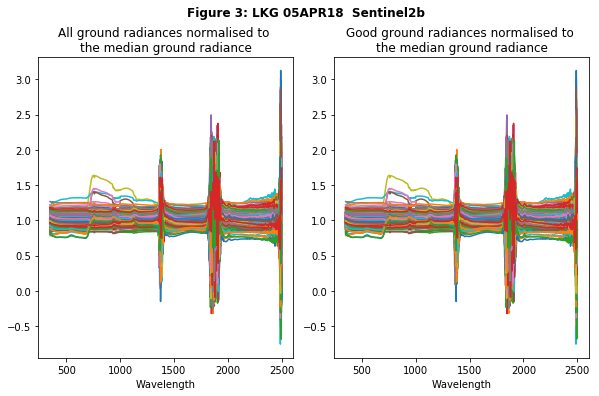

In [12]:
FIG_GroundSpectra.FIG_ground_spectra(good_grounds_spec, all_grounds_spec, output, field_data, fignum)
fignum +=1

### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [13]:
gpt, gpta, adt, adta = CreateTimeRelativeDF.create_time_relative_dfs(good_panels, all_panels, good_grounds, all_grounds)

# Figure 

### Plot timelines for ALL panel and ground data, with one line in one panel

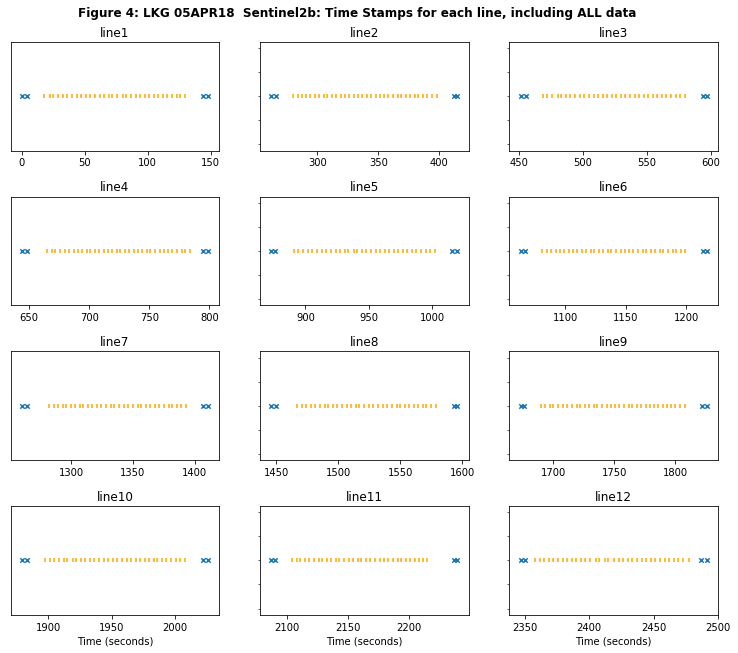

In [14]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, output, field_data, fignum)
fignum += 1

# Figure 

### Plot timelines for GOOD panel and ground data, with one line in one panel

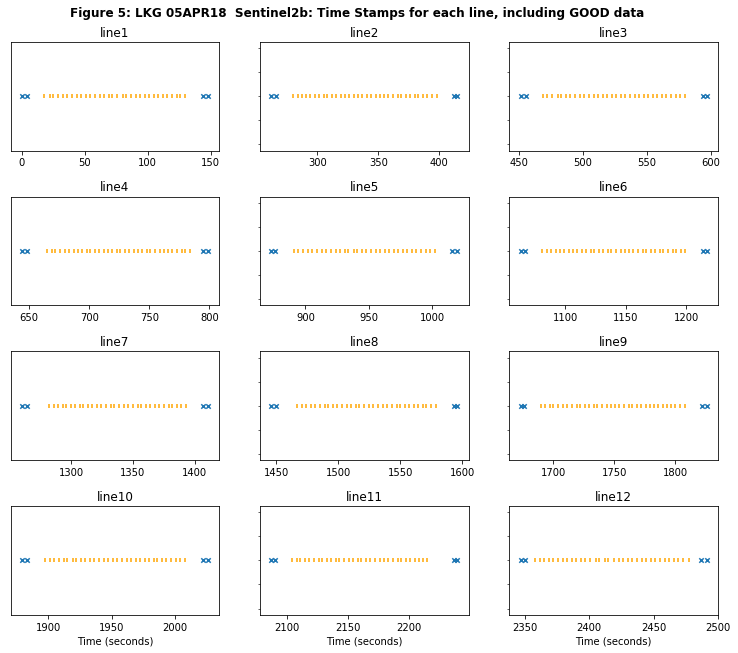

In [15]:
from CalVal.FIG_AllTimelines import panel_plot_layout, multi_timeline_plot

FIG_GoodTimelines.FIG_good_timelines(gpta, gpt, adt, panel_plot_layout, multi_timeline_plot, output, field_data, fignum)
fignum += 1

# Figure 

### Create timeline plot of averaged, normalised all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

In [16]:
#
# The following can be used to reload an edited module
#
#import importlib
#importlib.reload(CalVal.FIG_NormalisedPanelsTimeline)

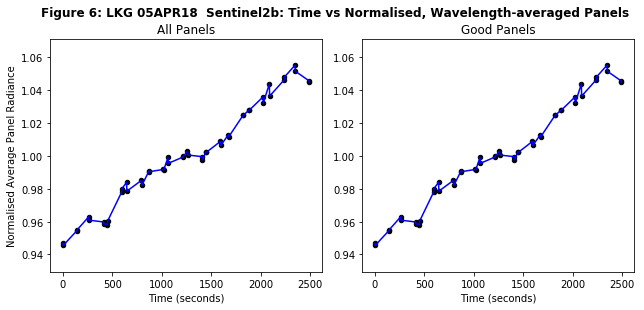

In [17]:
gpt, gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(good_panel_mean, good_panel_spec, all_panel_spec, gpt, gpta)
    
FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpt, gpta, output, field_data, fignum)
fignum += 1

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [18]:
k_f = KFactor.k_factor(panel_dir, in_panel)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [19]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec)

### Create dataframe with Reflectances

In [20]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f)

# Figure 

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

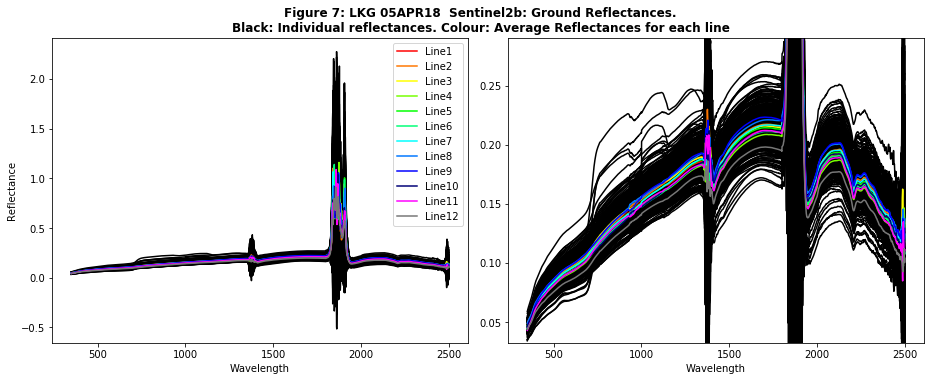

In [21]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, output, field_data, fignum)
fignum += 1

### Apply weighted band responses to all reflectances

In [22]:
result_df, band = ApplyWeights.apply_weights(f_name, all_refls)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [23]:
ground_bands = ReformatDF.reformat_df(good_grounds, result_df)

# Figure 

### Plot band reflectances

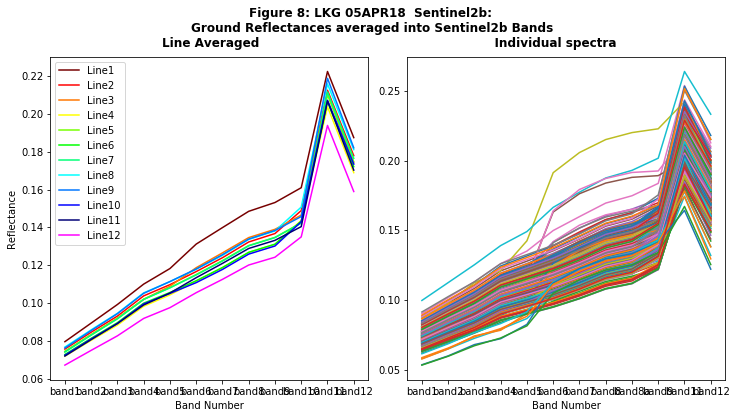

In [24]:
FIG_BandReflectances.FIG_band_reflectances(ground_bands, result_df, band, colpac, output, field_data, fignum)
fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

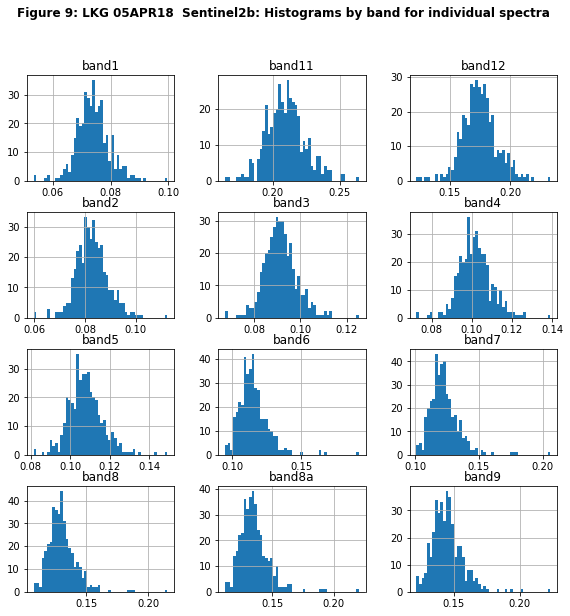

In [25]:
FIG_SpecHistogram.FIG_spec_histogram(ground_bands, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [26]:
maxfile = ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())]
maxbands = ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())]
minfile = ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())]
minbands = ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())]

print("Maximum value found in:", maxfile.iloc[0], '\n', maxbands.iloc[0], '\nMinimum value found in:', minfile.iloc[0], '\n', minbands.iloc[0])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())])


Maximum value found in: lkg_5-4-18-l100011.asd.rad 
 band1     0.099712
band2     0.112509
band3     0.125328
band4     0.139096
band5     0.149175
band6     0.166517
band7     0.177413
band8     0.187594
band8a    0.193075
band9     0.201811
band11    0.264035
band12    0.233345
Name: 9, dtype: float64 
Minimum value found in: lkg_5-4-18-l1200034.asd.rad 
 band1     0.053313
band2     0.059663
band3     0.067220
band4     0.072783
band5     0.081490
band6     0.104863
band7     0.114444
band8     0.121532
band8a    0.125359
band9     0.134133
band11    0.167185
band12    0.125454
Name: 392, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [27]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'], format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ground_bands['Solar_angle'] = ground_bands.apply(solar_angle, axis=1)

### Print out time stamp and coordinate extent

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

NOTE that you have to have the right module loaded first:

 > module use /g/data/v10/private/modules/modulefiles

 > module load wagl/5.1.0

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the directory /home/547/aw3463/brdf


In [28]:
#
# For LANDSAT 8
#
print("sed -i \"34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('",ground_bands['date_saved'][0],"'))/\" /home/547/aw3463/brdf/retrieve_brdf.py", sep='')
print("sed -i \"37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(",ground_bands['Longitude'].min(),", ", ground_bands['Latitude'].min(),", ",
      ground_bands['Longitude'].max(),", ", ground_bands['Latitude'].max(),")]})/\" /home/547/aw3463/brdf/retrieve_brdf.py", sep='')
print("python retrieve_brdf.py > temp.txt ; awk -f format.awk temp.txt")
print("")

#
# For Sentinel 2
#
print("sed -i \"34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('",ground_bands['date_saved'][0],"'))/\" /home/547/aw3463/brdf/retrieve_brdf.py", sep='')
print("sed -i \"37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(",ground_bands['Longitude'].min(),", ", ground_bands['Latitude'].min(),", ",
      ground_bands['Longitude'].max(),", ", ground_bands['Latitude'].max(),")]})/\" /home/547/aw3463/brdf/retrieve_brdf.py", sep='')
print("python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt")
print("")

sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-04-05 00:13:03'))/" /home/547/aw3463/brdf/retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(149.46124666666665, -35.092978333333335, 149.46271833333333, -35.09187333333333)]})/" /home/547/aw3463/brdf/retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format.awk temp.txt

sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-04-05 00:13:03'))/" /home/547/aw3463/brdf/retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(149.46124666666665, -35.092978333333335, 149.46271833333333, -35.09187333333333)]})/" /home/547/aw3463/brdf/retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [29]:
ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands)

### Choose between Landsat 8 and Sentinel satellite data

In the last two lines, swap "ls8_bands" and "senti_bands" for the appropriate satellite overpass.

In [30]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7,8]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

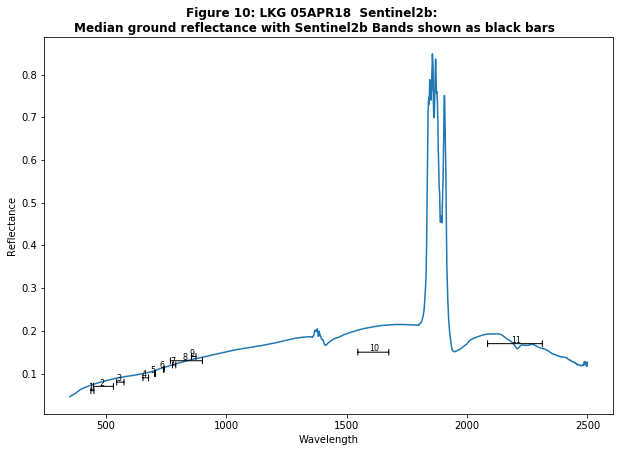

In [31]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Print field data time and Latitude/Longitude extents

The print outputs are used to manually feed the following query cell the right information<BR>
for the field data. Depending on how the field data align with satellite data, the longitude<BR>
and latitude extents may need to be adjusted.

In [32]:
print(ground_bands['date_saved'][0])
print(ground_bands['Latitude'].min(), ground_bands['Latitude'].max(),
      ground_bands['Longitude'].min(), ground_bands['Longitude'].max())


2018-04-05 00:13:03
-35.092978333333335 -35.09187333333333 149.46124666666665 149.46271833333333


# Figure 

### Plot relative locations of field and satellite data

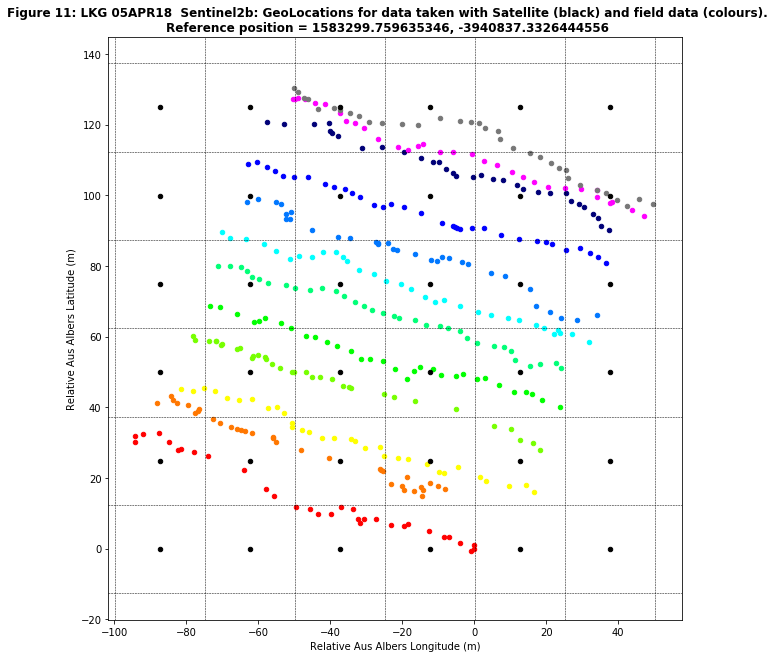

In [33]:
xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf, sat_array, colpac, output, field_data, fignum)
fignum +=1

### Create Australian albers columns for ground_brdf (not used)

In [34]:
#for i in range(len(ground_brdf)):
#    ground_brdf['Xalbers'], ground_brdf['Yalbers'] = pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i])
#    
#print(ground_brdf['Xalbers'][4], ground_brdf['Yalbers'][4])
#
#pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][4], ground_brdf['Latitude'][4])

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [35]:
field_array = CreateFieldFromSat.create_field_from_sat(sat_array, ground_brdf, xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

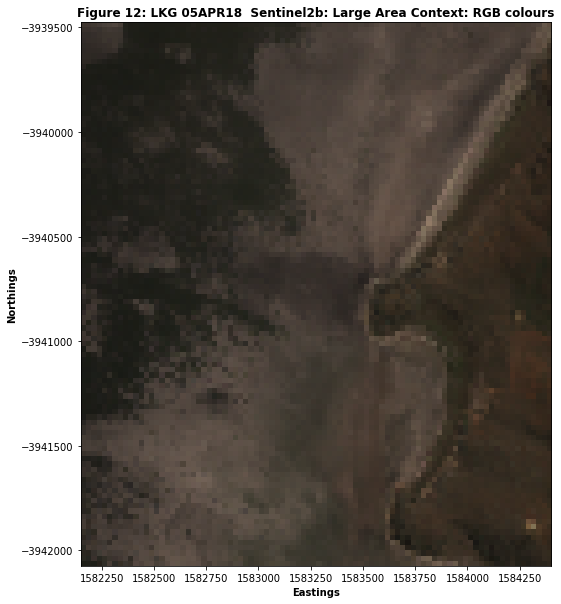

In [36]:
FIG_SatBigRGB.FIG_sat_bigRGB(sat_bigarray, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Satellite data

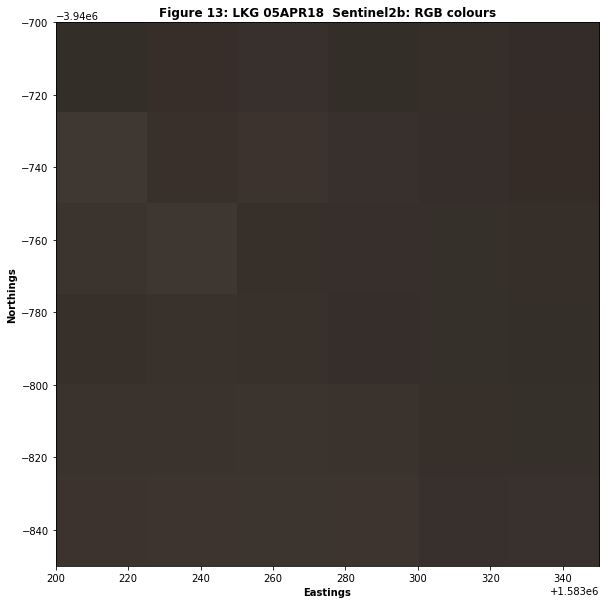

In [37]:
FIG_SatRGB.FIG_sat_RGB(sat_array, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


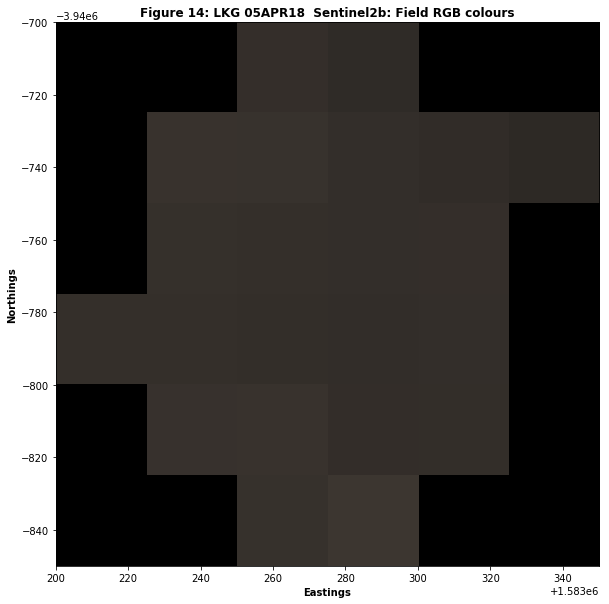

In [38]:
FIG_FieldRGB.FIG_field_RGB(field_array, output, field_data, fignum)
fignum += 1

### Test query for Sentinel 2 data (not used)

In [39]:
# dc2 = datacube.Datacube(config='/home/547/aw3463/sentinel2.config')
#
#query = {
#        'lat': (-35.25, -35.35),
#        'lon': (149.05, 149.17),
#        'output_crs': 'EPSG:3577',
#        'resolution': (-10, 10),
#        'time':('2017-10-01', '2018-05-15')
#        }
#
#canberra = dc2.load(product='s2b_ard_granule', **query)
#
#canberra

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

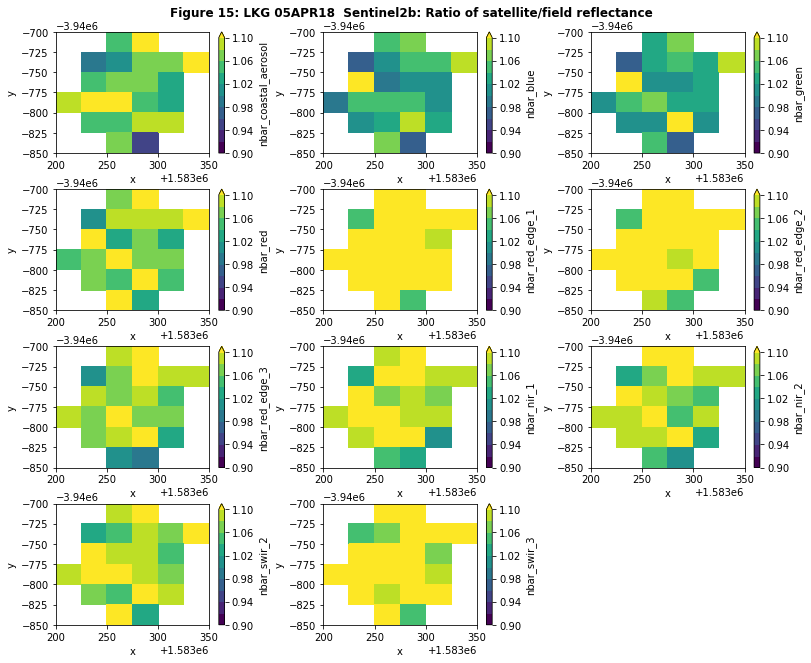

In [40]:
FIG_RatioArrays.FIG_ratio_arrays(sat_array, field_array, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [41]:
fstat_df = CreateStats.create_stats(sat_array, ground_brdf, field_data)

# Figure 

### Plot comparison spectra of ALL satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the field data, based on the standard deviation of the pixels<BR>
    within the field.

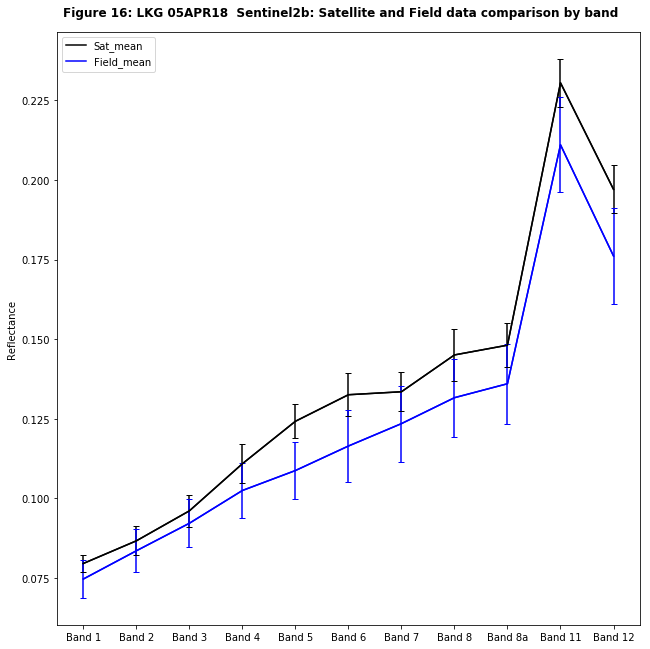

In [42]:
FIG_AllSatFieldBands.FIG_ALL_sat_field_bands(fstat_df, output, field_data, fignum)
fignum += 1

# Figure

### Plot comparison spectra of INNER satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the field data, based on the standard deviation of the pixels
within the field.

Only inner pixels are chosen to compare, where there are many field spectra for each satellite<BR>
    pixel. For example, using [2:4,2:4] will choose four pixels between coordinates (2,2) and (3,3),<BR>
    inclusive, from the top-left corner.

In [43]:
finner_df = CreateSubStats.create_SUB_stats(sat_array, field_array, fstat_df, inpix, field_data)

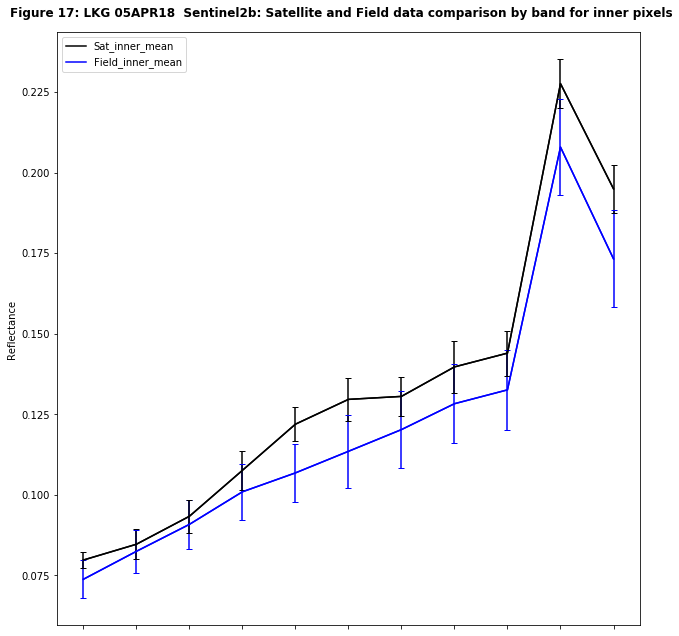

In [44]:
FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(finner_df, output, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

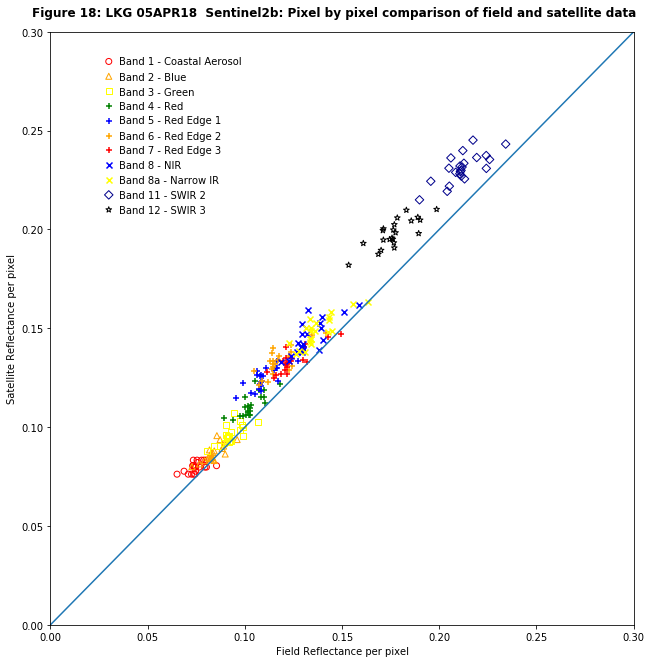

In [45]:
plot_scale = [0.0, 0.3, 0.0, 0.3]
FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(sat_array, field_array, plot_scale, output, field_data, fignum)
fignum += 1

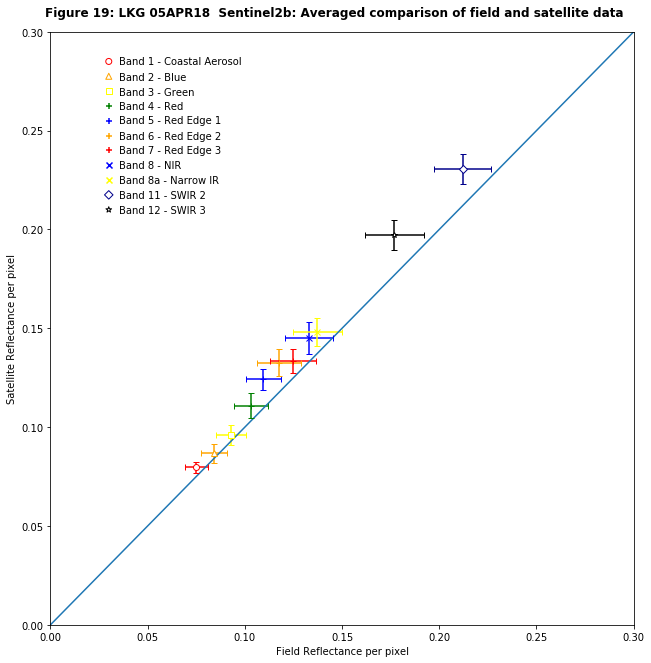

In [46]:
FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(sat_array, field_array, plot_scale, fstat_df, output, field_data, fignum)
fignum += 1